In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# native tools
import sys
from copy import copy
from collections import Counter

# for data analysis 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature selection
from sklearn.feature_selection import VarianceThreshold

# for outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# for imbalanced classes
from imblearn.over_sampling import SMOTENC

# custom functions, classes, etc ... 
sys.path.append("../Scripts")
from eda_helper_functions import (drop_low_var_features, 
                                  load_dataset, 
                                  identify_categorical_features, 
                                  statistical_outlier_removal, 
                                  filter_features_using_correlation, 
                                  get_continue_features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----

# Exploratory Data Analysis (EDA)

The purpose of this notebook is to
- Explore the extent that cleaning is necessary (imbalanced classes, missing values, outliers, ... )
- Use data to inform how to best prep data for modeling

### Load data

In [2]:
data_path = "../Data/fraud_detection_bank_dataset.csv"
df = load_dataset(data_path)

### Check missing values

In [3]:
# no null values 
df.isnull().sum().sum()

0

### Drop completely useless features

In [4]:
# drop all zero variance features from dataset
# we might need to comeback and increase the variance threshold later 
df = drop_low_var_features(df, threshold=0.0)

Number of features dropped 15


### Distinguish between continuous and categorical features 

In [5]:
# list with names of categorical features
categorical_feat_names = identify_categorical_features(df, 
                                                       threshold=5, 
                                                       target_feat_name=None)

----
## Filter features based on correlations

### Linear correlations between Target and continuous variables
Pearson correlation metric is valid for:
- Only linear relationships between continuous variables 

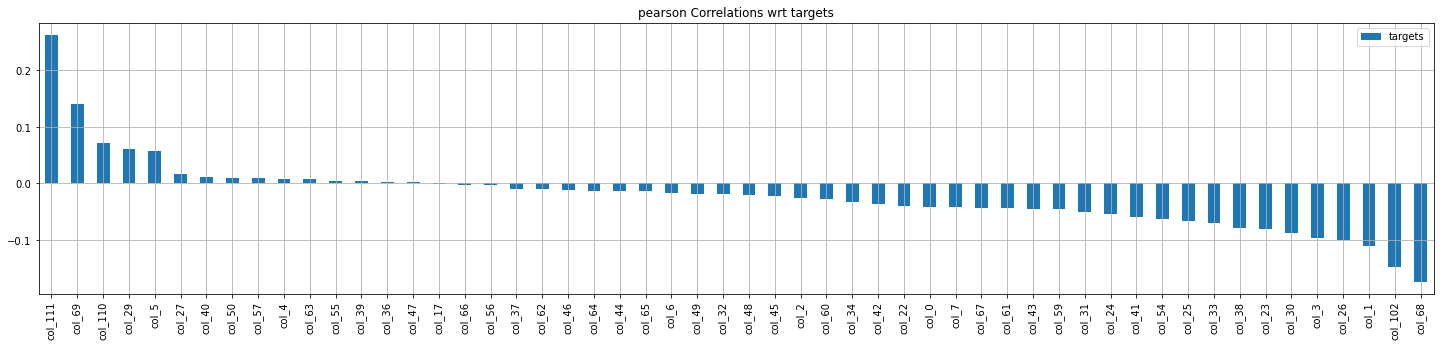

In [38]:
corr_method = "pearson"
y_col_name = "targets"
corr_thresh = 0.1

# get names of features with continuous values 
continuous_feats = get_continue_features(df, categorical_feat_names, y_col_name)

# get names of features with a corr wrt targets that is greater than corr_thresh
df_corr, strong_corr_feats = filter_features_using_correlation(df[continuous_feats], corr_method, corr_thresh, y_col_name)

# plot results
title = "{0} Correlations wrt {1}".format(corr_method, y_col_name)
df_corr.plot(kind="bar", figsize=(25,5), grid=True, title=title);
plt.show()

In [39]:
# by applying a threshold to the abs value of the correlations
# we can filter out weak correlating features and keep the stronger ones 
strong_corr_feats

Index(['col_111', 'col_69', 'col_110', 'col_29', 'col_5', 'col_27', 'col_40',
       'col_50', 'col_57', 'col_4', 'col_63', 'col_55', 'col_39', 'col_36',
       'col_47', 'col_17', 'col_66', 'col_56', 'col_37', 'col_62', 'col_46',
       'col_64', 'col_44', 'col_65', 'col_6', 'col_49', 'col_32', 'col_48',
       'col_45', 'col_2', 'col_60', 'col_34', 'col_42', 'col_22', 'col_0',
       'col_7', 'col_67', 'col_61', 'col_43', 'col_59', 'col_31', 'col_24',
       'col_41', 'col_54', 'col_25', 'col_33', 'col_38', 'col_23', 'col_30',
       'col_3', 'col_26', 'col_1', 'col_102', 'col_68'],
      dtype='object')

### Ranked Correlations between Target and all variabels
Spearman correlation metric is valid for:
- both linear and non-linear relatinships
- continues and ordinal variables (i.e. "bad", "good", "great")

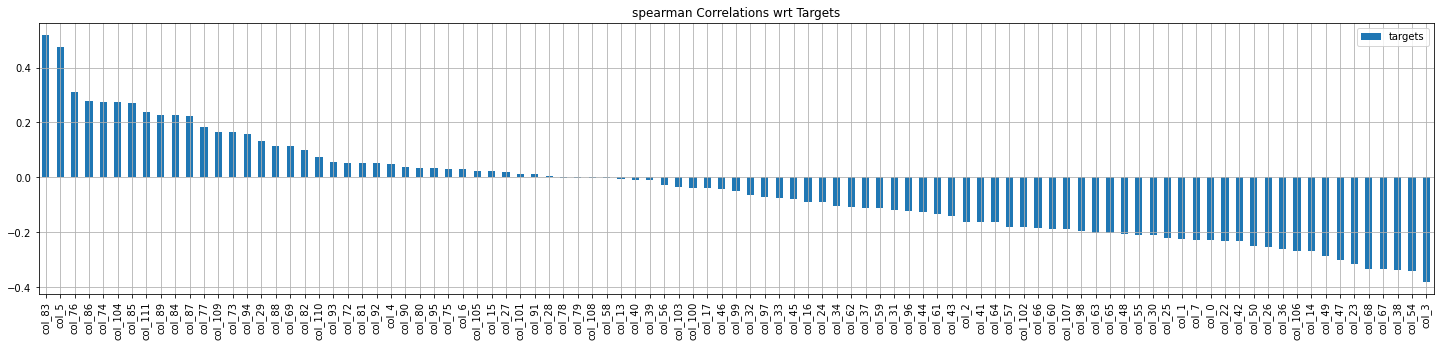

In [42]:
corr_method = "spearman"
y_col_name = "targets"
corr_thresh = 0.1

# get names of features with a corr wrt targets that is greater than corr_thresh
df_corr, strong_corr_feats = filter_features_using_correlation(df, corr_method, corr_thresh, y_col_name)

# plot results
title = "{} Correlations wrt Targets".format(corr_type)
df_corr.plot(kind="bar", figsize=(25,5), grid=True, title=title);

### Observations 

Notice that `col_3` has a `Pearson's correlation of just below -0.1` and a `Spearmon's correlation of just below -0.4`. This indicates that `col_3` (and others like it) should have a strong non-linear relationship with the target variable. 

Therefore, a non-linear model should perform better than a linear model wrt to features like `col_3`. 

This suggest a couple of things:
- Train both linear and non-linear models on the features with large spearman corr values 
- For the linear model, train it using the strongly linear features and using all the features and compare results 

In [43]:
# by applying a threshold to the abs value of the correlations
# we can filter out weak correlating features and keep the stronger ones 
strong_corr_feats

Index(['col_83', 'col_5', 'col_76', 'col_86', 'col_74', 'col_104', 'col_85',
       'col_111', 'col_89', 'col_84', 'col_87', 'col_77', 'col_109', 'col_73',
       'col_94', 'col_29', 'col_88', 'col_69', 'col_82', 'col_110', 'col_93',
       'col_72', 'col_81', 'col_92', 'col_4', 'col_90', 'col_80', 'col_95',
       'col_75', 'col_6', 'col_105', 'col_15', 'col_27', 'col_101', 'col_91',
       'col_28', 'col_78', 'col_79', 'col_108', 'col_58', 'col_13', 'col_40',
       'col_39', 'col_56', 'col_103', 'col_100', 'col_17', 'col_46', 'col_99',
       'col_32', 'col_97', 'col_33', 'col_45', 'col_16', 'col_24', 'col_34',
       'col_62', 'col_37', 'col_59', 'col_31', 'col_96', 'col_44', 'col_61',
       'col_43', 'col_2', 'col_41', 'col_64', 'col_57', 'col_102', 'col_66',
       'col_60', 'col_107', 'col_98', 'col_63', 'col_65', 'col_48', 'col_55',
       'col_30', 'col_25', 'col_1', 'col_7', 'col_0', 'col_22', 'col_42',
       'col_50', 'col_26', 'col_36', 'col_106', 'col_14', 'col_49', 'col

-----
## Identify, Detect, and Remove Outliers

We'll explore 3 different outlier detection approaches
1) Statistical
2) Isolation Forest
3) One-Class SVM 

In [10]:
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.038646,0.363152,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.192754,0.480920,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


A quick glance at a statstical table will show us that features `col_1`, `col_2`, `col_3` and others clearly have outliers by comparing the 75th percentile values with the max values. So outliers are clearly present. The question then becomes how to best identify and remove them in an automated way.  

Keep in mind that, at this point, we don't know if removing the outliers will increase, decrease, or have a neutral affect on our models. So we'll use this notebook to identify a couple of outlier detectors but, ultimately, we'll need to train models on various versions of the data set (with outliers and without) to see that leads to the best performing models. 

If could be the case that what we see as "outliers" might actually be predictive of fraud. Which is plausable at this point. Recall that the labels are imbalanced, so these low volume "outliers" might actually correspond to the low volumn positive labels indicating fraud. 

Having said all that, let's create use statistics to remove outliers.

### 1) Outlier detection via distribution statistics 

Let's create a `simple baseline outlier detector` using the mean/median and the std. This algorithm knows to `only filter samples in continuous valued variables`. 

Binary features don't have outliers, they are imbalanced (more on that later).

In [11]:
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.038646,0.363152,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.192754,0.480920,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


In [12]:
df_outliers_removed = statistical_outlier_removal(df, bias="mean", n_std=2)
df_outliers_removed.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,...,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.000000,15129.0,15129.000000,15129.000000
mean,1.266706,125.640624,0.217728,1.327583,0.036751,0.578426,2.298103,1.266706,0.033512,0.314495,...,0.001256,0.343579,0.000463,0.228237,0.110847,0.000066,0.038403,0.0,29.234318,0.284817
std,3.501783,161.935881,0.810380,1.837396,0.188155,0.930604,2.974459,3.501783,0.179975,0.464330,...,0.035417,0.474918,0.021506,0.419710,0.313953,0.008130,0.192174,0.0,33.602346,0.451342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
50%,0.000000,66.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.000000,0.000000
75%,1.000000,155.000000,0.000000,2.000000,0.000000,1.000000,6.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,53.000000,1.000000
max,44.000000,1716.000000,15.000000,22.000000,1.000000,9.000000,8.000000,44.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,161.000000,1.000000


By setting `n_std=2` we have gone from a max value of 37,808 to 1,716 for `col_1`. Is this good? In our context, "good" is closely related to what maximizes model performance. So we'll have to gridsearch `n_std` to find out which value is "good",

### 2) Outlier detection via Isolation Forest

Isolation Forest isn't as aggressive as our baseline statistical approach. Which of the two appraoch are "better" will be determined by model scores. 

In [13]:
# IsolationForest hyper-parameters can be gridsearched later
iforest = IsolationForest()

# -1 for outlier and 1 for inliner
# when modeling only use training set for fit, otherwise dataleakage 
iforest_results = iforest.fit_predict(df) 

# map (-1,1) to (False, True)
keep_samples_mask = [False if val == -1  else True for val in iforest_results]
df[keep_samples_mask].describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,...,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000,19754.000000
mean,2.369191,217.687203,0.304394,1.857700,0.073150,0.705730,2.391313,2.369191,0.036803,0.349904,...,0.003037,0.356535,0.001873,0.290827,0.168017,0.000051,0.041511,0.010175,39.457173,0.267996
std,9.335239,351.481123,2.183000,5.478441,0.667888,1.660748,3.019027,9.335239,0.188282,0.476951,...,0.056840,0.478988,0.043239,0.454155,0.373890,0.007115,0.199473,0.121782,50.208950,0.442927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,91.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
75%,2.000000,252.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,59.000000,1.000000
max,420.000000,7830.000000,150.000000,360.000000,54.000000,57.000000,11.000000,420.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,501.000000,1.000000


### 3) One-Class SVM

This approach is the most aggressive when it comes to dropping samples. We are left with about half of our initial 20K points. 

In [14]:
# again, we can gridsearch hyper-parameters when modeling
svm = OneClassSVM()

# -1 for outlier and 1 for inliner
# when modeling only use training set for fit, otherwise dataleakage 
svm_results = svm.fit_predict(df)

# map (-1,1) to (False, True)
keep_samples_mask = [False if val == -1  else True for val in svm_results]
df[keep_samples_mask].describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,...,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.000000,9535.00000
mean,4.410068,429.184373,0.566964,3.119350,0.110750,1.064604,2.439014,4.410068,0.047299,0.457158,...,0.007341,0.356057,0.003776,0.397378,0.262926,0.000105,0.042685,0.032512,43.455270,0.15784
std,15.891548,756.726232,5.232511,13.216898,0.960356,5.087489,3.069851,15.891548,0.212290,0.498187,...,0.088981,0.478857,0.061333,0.489381,0.440246,0.010241,0.202156,0.361500,57.889909,0.36461
min,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.00000
50%,1.000000,181.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.00000
75%,3.000000,422.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,59.000000,0.00000
max,490.000000,12179.000000,223.000000,772.000000,54.000000,184.000000,8.000000,490.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,713.000000,1.00000


-------
## Balancing Imbalanced Classes 

Our labels are severely imbalanced. There are about 3 negative cases (no fraud) for every 1 positive case (yes fraud). This is problematic because it will bias the learning outcome of our model. 

There are at least 3 different ways to address this problem:
1) Undersample the majority class (will reduce the total number of available samples down to the number of minority samples)
2) Oversample the minority class (may lead to overfitting)
3) Create synthetic minority class samples using [SMOTE](https://github.com/scikit-learn-contrib/imbalanced-learn) in order to balance the classes 

The 3rd option is actually a library of many different algorithms that create synthetic minority samples depending on the particularities of your dataset. 

For instance, `our dataset has both continuous and categorical values`. In which case the SMOTE documentaion recommend that we specifically work with [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) which stands for `Synethetic minority Over-sampling Technique for Nominal and Continuous`

In [52]:
Counter(df.targets)

Counter({1: 5438, 0: 15030})

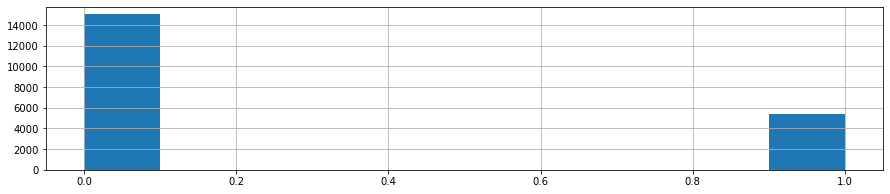

In [53]:
df.targets.hist(figsize=(15,3), grid=True);

In [83]:
# cate_feat_names doesn't contain "targets"
cate_feat_mask = df.columns.isin(cate_feat_names)
sm = SMOTENC(random_state=42, 
             categorical_features=cate_feat_mask, 
             k_neighbors=5) # number of neighbors to use when creating a synthetic sample 

# move data into arrays 
y = df.targets.values
x_cols = df.columns.drop(["targets"])
x = df[x_cols].values

# when modeling, only fit on training
x_resampled, y_resampled = sm.fit_resample(x, y)

# create a dataframe with the resampled data
y_resampled = y_resampled.reshape((y_resampled.shape[0], 1))
data_resampled = np.concatenate([x_resampled, y_resampled], axis=1)
df_resampled = pd.DataFrame(data=data_resampled, columns=df.columns)

In [99]:
# in order to balance the labels, SMOTENC has created about 10K syntheic samples for the minority class 
df.shape, df_resampled.shape

((20468, 98), (30060, 98))

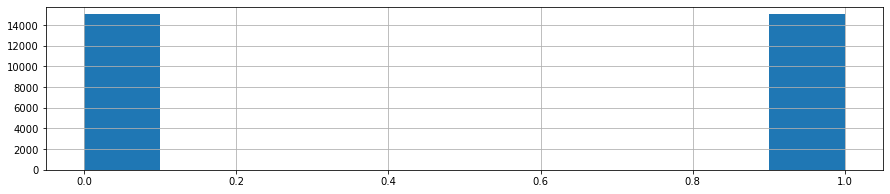

In [101]:
# balanced classes! 
df_resampled.targets.hist(figsize=(15,3), grid=True);

Quick note, when modeling we only want to use the training set when generating the synthetic samples in order to balance out the data during the model's training, while using the a non-syntehtic test set during inference. Why? Because the model will not be seeing any synthetic samples in production, therefore that is what we need to score during model inference. 

Additionally, we ask if these synthetic samples are actually any good. Well, as usual, this is a question that we will answer during modeling building; if it leads to the best performing model during inference then it's good, otherwise no. 

----
# Conclusion

In this notebook, we have explore various feature selection approaches 
 - Minimum Variance threshold
 - Minimum Correlation threshold using Pearson and Spearman
 
We've explore different outlier detection algorithms
 - Baseline distribution statistical filter
 - Isolation Forest
 - One-Class SVM
 
We addressed how to balance classes 
 - SMOTENC for data with continuous and categorical data
 
 
 
In the next notebook, we'll be taking what we learned here in order to build a `Machine Learning pipeline` for model training and selection. 